In [113]:
import numpy as np
import time
import networkx as nx
import matplotlib.pyplot as plt
import random
from qiskit import (QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer)
#%matplotlib qt
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider(group='open')

Credentials are already in use. The existing account in the session will be replaced.


In [114]:
def counts_to_prob_1d(counts):
    # Convert histogram counts to probability vector of size 1 x 2^n
    states = list(counts.keys())
    state_counts = list(counts.values())
    nshots = sum(state_counts)
    # Convert binary to integer index, reversing order as consistent w qiskit convention
    states_x = [int(s[::-1],2) for s in states]
    # Create array of probability values
    probabilities = np.zeros(2**n)
    probabilities[states_x] = state_counts
    probabilities /= nshots
    return probabilities

In [115]:
def increment_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        circuit.mct([qcoin[0]]+qpos[i+1:], qpos[i], None, mode='noancilla')
        
def decrement_gate(circuit, qpos, qcoin):
    n = len(qpos)
    circuit.x(qcoin[0])
    for i in range(n):
        if i+1 < n: circuit.x(qpos[i+1:])
        circuit.mct([qcoin[0]]+qpos[i+1:], qpos[i], None, mode='noancilla')
        if i+1 < n: circuit.x(qpos[i+1:])
            
def step(circuit, qpos, qcoin,cpos,simulatorType):
    circuit.h(qcoin)
    circuit.barrier()
    increment_gate(circuit, qpos, qcoin)
    circuit.barrier()
    decrement_gate(circuit, qpos, qcoin)
    circuit.barrier()
    if simulatorType == 'classical':
        circuit.measure(qpos,cpos)

def run(steps,simulatorType):
    # steps = number of quantum walks steps
    # simulatorType = 'sim', 'quantum' or 'classical'
    
    if simulatorType == 'sim':
        simulator = Aer.get_backend('qasm_simulator')
    elif simulatorType == 'quantum':
        simulator = provider.get_backend('ibmq_5_yorktown')
    elif simulatorType == 'classical':
        simulator = Aer.get_backend('qasm_simulator')
    else:
        simulator = Aer.get_backend('qasm_simulator')
    
    qpos = QuantumRegister(n,'qc')
    qcoin = QuantumRegister(1,'qanc')
    cpos = ClassicalRegister(n,'cr')
    circuit = QuantumCircuit(qpos, qcoin, cpos)
    for i in range(steps):
        step(circuit, qpos, qcoin,cpos, simulatorType)
    # # Map the quantum measurement to the classical bits
    circuit.measure(qpos,cpos)
    # # Execute the circuit on the qasm simulator
    job = execute(circuit, simulator, shots=1000)
    # # monitor job
    job_monitor(job)
    # # Grab results from the job
    result = job.result()
    # # Returns counts
    counts = result.get_counts(circuit)
    return counts

In [116]:
seed = 12
random.seed(seed)
np.random.seed(seed)
def plotCircleGraph(names,propabilities):
    G = nx.Graph()
    colorarray = []
    # generate array of colors
    numProp = len(propabilities)
    for idx in range(numProp):
        colorarray.append([1-propabilities[idx],1-propabilities[idx],1])
    # generate graph
    for idx in range(numProp-1):
        G.add_edge(idx, idx+1)
    # add last edge
    G.add_edge(0,numProp-1)
    # label nodes
    labels = {}
    for idx in range(numProp-1):
        labels[idx] = names[idx]
    
    nx.draw(G,pos=nx.circular_layout(G),node_color = colorarray,cmap=plt.cm.Blues)
    pos=nx.circular_layout(G)
    labels = nx.draw_networkx_labels(G,pos,labels,font_size=16)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


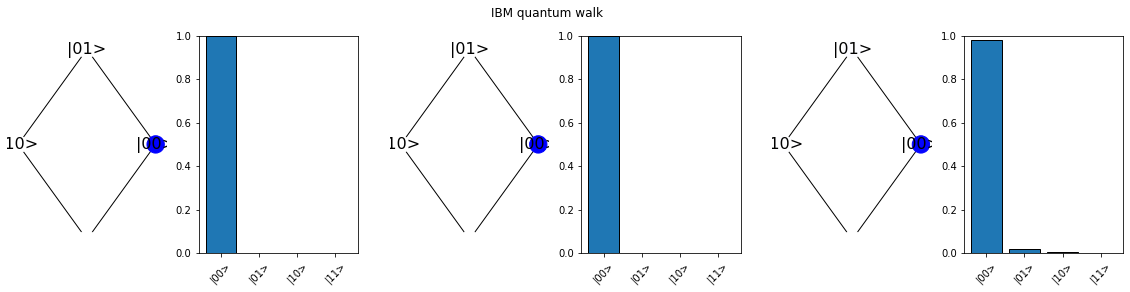

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


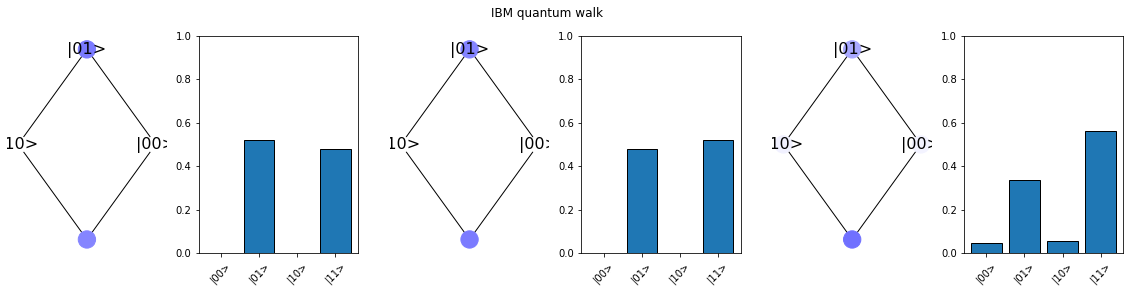

In [117]:
# run and plot 1D walk

steps = 1
n=2

for i in range(steps+1):
    #run classical random walk
    countsClassical = run(i,'classical')
    propClassical = counts_to_prob_1d(countsClassical)
    #run quantum simulation
    countsSim = run(i,'sim')
    propSim = counts_to_prob_1d(countsSim)
    #run the real thing
    countsQuantum = run(i,'quantum')
    propQuantum = counts_to_prob_1d(countsQuantum)
    
    #plotting
    f, axs = plt.subplots(1,6,figsize=(20,4))
    
    names = []
    formatLabel = '{0:0'+str(n)+'b}'
    for idx in range(2**n):
        names.append('|' + formatLabel.format(idx) +'>')
    
    plt.suptitle('simulated quantum walk')
    plt.subplot(161)
    plotCircleGraph(names,propClassical)
    plt.subplot(162)
    plt.bar(names,propClassical,edgecolor='black')
    plt.ylim(0,1) 
    plt.xticks(rotation=45)
    
    plt.suptitle('simulated quantum walk')
    plt.subplot(163)
    plotCircleGraph(names,propSim)
    plt.subplot(164)
    plt.bar(names,propSim,edgecolor='black')
    plt.ylim(0,1) 
    plt.xticks(rotation=45)
    
    plt.suptitle('IBM quantum walk')
    plt.subplot(165)
    plotCircleGraph(names,propQuantum)
    plt.subplot(166)
    plt.bar(names,propQuantum,edgecolor='black')
    plt.ylim(0,1) 
    plt.xticks(rotation=45)
    
    
    plt.show()
    plt.close()